## Introduction
In this notebook, the algorithm used to position modules in a deep learning model architecture is experimented with

## Imports

In [1]:
from typing import List, Tuple, Set, Type
import torch
from torch import nn, tensor
import matplotlib.pyplot as plt
from matplotlib import patches, lines
from collections import deque
from munkres import Munkres
import random
import itertools
import numpy as np

## Type definitions
* Two ways in which this can be written shorter
  - Using `fc.store_attr()` from `fastcore` to store passed attributes in `__init__`
  - Skipping explicit typing
* This is a tradeoff and in this case, writing this in the slightly longer way saved considerable development time by making VSCode's intellisense work better

In [2]:
class MavNode:
    def __init__(self, name, y, x):
        self.name, self.y, self.x = name, y, x
        self._idx = None  # Index within graph
        self._in_nodes:List[MavNode] = []
        self._out_nodes:List[MavNode] = []
    def __repr__(self):
        return f'MavNode: name={self.name}; (x,y)=({self.x},{self.y}); in={[n.name for n in self._in_nodes]}, out={[n.name for n in self._out_nodes]}'

class MavConnection:
    def __init__(self, from_node:MavNode, to_node:MavNode):
        self.from_node, self.to_node = from_node, to_node

class MavGraph:
    def __init__(self, nodes:List[MavNode], connections:List[MavConnection]):
        self.nodes = nodes
        self.connections = connections
        self.nw = 0.5  # Node width
        self.nh = 0.5  # Node height
        self._assign_in_out_nodes()

    def __repr__(self):
        lines = []
        lines.append(f'Inputs: {[n.name for n in self.in_nodes]}')
        lines.append(f'Outputs: {[n.name for n in self.out_nodes]}')
        lines.append('All nodes:')
        lines += [f'    {n.__repr__()}' for n in self.nodes]
        return '\n'.join(lines)

    def _assign_in_out_nodes(self):
        for i,n in enumerate(self.nodes): n._idx = i

        for c in self.connections:
            if not c.to_node in c.from_node._out_nodes:
                c.from_node._out_nodes.append(c.to_node)
            if not c.from_node in c.to_node._in_nodes:
                c.to_node._in_nodes.append(c.from_node)
        
        # Graph input and output nodes
        self.in_nodes = [node for node in self.nodes if not node._in_nodes]
        self.out_nodes = [node for node in self.nodes if not node._out_nodes]

## Graph generation functions

In [3]:
def create_sample_graph():
    nodes = [
        MavNode("0", 0, 0),
        MavNode("1", 1, 0),
        MavNode("2", 1, 1),
        MavNode("3", 2, -1),
        MavNode("4", 2, 0),
        MavNode("5", 2, 1),
        MavNode("6", 2, 2),
    ]
    connections = [
        MavConnection(nodes[0], nodes[1]),
        MavConnection(nodes[0], nodes[2]),
        MavConnection(nodes[1], nodes[3]),
        MavConnection(nodes[1], nodes[4]),
        MavConnection(nodes[2], nodes[5]),
        MavConnection(nodes[2], nodes[6]),
    ]
    return MavGraph(nodes=nodes, connections=connections)

In [4]:
def create_random_sample_graph(num_nodes, num_connections):
    nodes = [MavNode(str(ni), 0, 0) for ni in range(num_nodes)]
    connection_tuples: List[Tuple[int]] = []
    connections: List[MavConnection] = []
    num_attempts = 0
    while len(connections) < num_connections and num_attempts < num_connections*10:
        n1 = random.randint(0, num_nodes-1)
        n2 = random.randint(0, num_nodes-1)
        if n1>n2: n_temp = n1; n1 = n2; n2 = n_temp
        reject = n1==n2 or (n1,n2) in connection_tuples
        if not reject:
            connection_tuples.append((n1,n2))
            connections.append(MavConnection(nodes[n1], nodes[n2]))
        num_attempts += 1
    return MavGraph(nodes=nodes, connections=connections)

## Simple viewer

In [5]:
def draw_graph(g:MavGraph):
    fig, ax = plt.subplots()
    x_lim, y_lim = (0,0), (0,0)
    for n in g.nodes:
        rect = patches.Rectangle((n.x - g.nw/2, n.y - g.nh/2), g.nw, g.nh, 
                                linewidth=1, edgecolor=[0,0,0], facecolor='none')
        ax.add_patch(rect)
        x_lim = (min((x_lim[0], n.x-1)), max((x_lim[1], n.x+1)))
        y_lim = (min((y_lim[0], n.y-1)), max((y_lim[1], n.y+1)))
        ax.text(n.x, n.y, n.name, horizontalalignment='center', verticalalignment='center')
    for c in g.connections:
        xdata=[c.from_node.x, c.to_node.x]
        ydata=[c.from_node.y + g.nh/2, c.to_node.y - g.nh/2]
        line = lines.Line2D(xdata=xdata, ydata=ydata, linewidth=1, color=[0,0,0])
        ax.add_line(line)
    ax.set_xlim(left=x_lim[0], right=x_lim[1])
    ax.set_ylim(bottom=y_lim[1], top=y_lim[0])
    ax.set_yticks([])
    ax.set_xticks([])

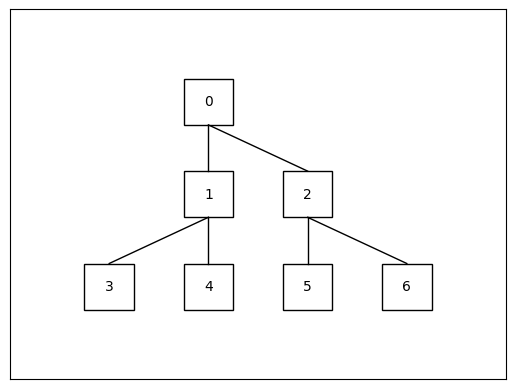

In [6]:
g1 = create_sample_graph()
draw_graph(g1)

In [7]:
g1

Inputs: ['0']
Outputs: ['3', '4', '5', '6']
All nodes:
    MavNode: name=0; (x,y)=(0,0); in=[], out=['1', '2']
    MavNode: name=1; (x,y)=(0,1); in=['0'], out=['3', '4']
    MavNode: name=2; (x,y)=(1,1); in=['0'], out=['5', '6']
    MavNode: name=3; (x,y)=(-1,2); in=['1'], out=[]
    MavNode: name=4; (x,y)=(0,2); in=['1'], out=[]
    MavNode: name=5; (x,y)=(1,2); in=['2'], out=[]
    MavNode: name=6; (x,y)=(2,2); in=['2'], out=[]

## Layout algorithm
Given node names and connections, calculate the best `x` and `y` for each node

## Level assignment (y-values)
* Specification
  - Final levels are numbered from `0` (input nodes) to `num_levels` (output nodes)
  - A node is placed on level `L` if the lowest level of all its direct outputs is `L+1`
* Implemented as breadth-first search starting with output nodes
  - Because the number of levels is not known beforehand, the first pass assigns negative level numbers and counts the number of levels. A second pass offsets all level numbers by the same amount to have the input nodes at level `0` 
  - Start by assigning output nodes as level 0 and nodes that input to another node one level higher
    - After this pass, all but the output nodes will have negative level numbers
  - When done, subtract the minimum level number from that of all nodes
    - After this pass, the input nodes will have level 0 and all others will have positive numbers 

In [8]:
g1

Inputs: ['0']
Outputs: ['3', '4', '5', '6']
All nodes:
    MavNode: name=0; (x,y)=(0,0); in=[], out=['1', '2']
    MavNode: name=1; (x,y)=(0,1); in=['0'], out=['3', '4']
    MavNode: name=2; (x,y)=(1,1); in=['0'], out=['5', '6']
    MavNode: name=3; (x,y)=(-1,2); in=['1'], out=[]
    MavNode: name=4; (x,y)=(0,2); in=['1'], out=[]
    MavNode: name=5; (x,y)=(1,2); in=['2'], out=[]
    MavNode: name=6; (x,y)=(2,2); in=['2'], out=[]

In [9]:
def calc_levels(g:MavGraph, verbose=False):
    
    # Breadth-first search
    queue = deque(g.out_nodes)  # Initialize to contain all output nodes
    visited = set(g.out_nodes)
    min_level_number = 0
    while queue:
        if verbose: print([n.name for n in queue])
        cur_node = queue.popleft()
        if cur_node._out_nodes:
            # Set level to just before than earliest output node
            cur_node.y = min([n.y-1 for n in cur_node._out_nodes])
        else:
            # Node is an output node. Set level to 0
            cur_node.y = 0

        if cur_node.y < min_level_number: min_level_number = cur_node.y

        # Queue all input nodes of current node that have all their outputs visited
        for in_node in cur_node._in_nodes:
            if in_node in visited: continue
            if not all([o in visited for o in in_node._out_nodes]): continue
            queue.append(in_node)
            visited.add(in_node)

    # Adjust to have inputs at level 0
    # * Other nodes move up by the same amount
    # * Also populate the return object: A list of lists of nodes indices at each level
    num_levels = 1 - min_level_number
    nodes_on_each_level = [[] for i in range(num_levels)]
    for i,n in enumerate(g.nodes):
        if n in g.in_nodes:
            n.y = 0
        else:
            n.y = n.y - min_level_number
        nodes_on_each_level[n.y].append(i)

    return nodes_on_each_level

In [10]:
calc_levels(g1, verbose=True)

['3', '4', '5', '6']
['4', '5', '6', '1']
['5', '6', '1']
['6', '1', '2']
['1', '2']
['2', '0']
['0']


[[0], [1, 2], [3, 4, 5, 6]]

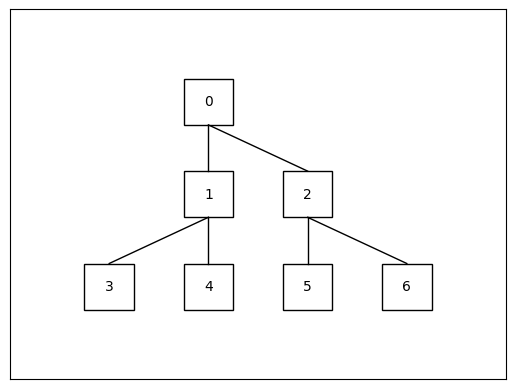

In [11]:
draw_graph(g1)

# Ordering within levels (x-values)



### Initial design
* The initial idea was to use a dynamic programming (DP) algorithm where one level of modules is added at a time
* For each level, the lowest-cost path to `num_assgn` different assignments of modules to positions on that level would be stored
  - This is a trade-off for the sake of speed, because the globally optimal layout may not use one of the `num_assgn` most optimal assignments on a particular level
  - There is no need for an optimal layout: a near-optimal one would also aid the user in visualizing network structure 
* To obtain the `num_assgn` most optimal assignments on a particular level is a ranked assignment problem which is typically best solved by Murty's algorithm ([Original paper](https://www.jstor.org/stable/168595), [Fast implementation](https://ieeexplore.ieee.org/document/599256))
  - Several implementations are available, e.g. [fbaeuerlein](https://github.com/fbaeuerlein/MurtyAlgorithm), [arg0naut91](https://github.com/arg0naut91/muRty), [lauziere](https://github.com/lauziere/Murty)
* We planned on using a greedy algorithm instead of Murty's algorithm for several reasons:
  - Execution speed (it is already an inner loop inside a DP algorithm)
  - Limiting the number of dependencies
  - The outer DP algorithm may produce better globally solutions if local candidate solutions are forced to vary more in structure
  - There is no need for an optimal layout: a near-optimal one should also aid the user in visualizing network structure


#### Errors in initial design
* One cannot have a different set of assignments at level `L` for different sets at level `L-1`. This would break the assumptions of the DP algorithm
* Another DP assumption was invalid. The minimum-cost path to a certain configuration on level `L` may not be the minimum-cost path to a configuration on level `L+1`, even if that configuration uses the same configuration at level `L`. Because of things like skip connections, more earlier levels must be taken into account when determining the next level.   

### Hungarian algorithm-based approach
This approach is by no means optimal in terms of global minimum cost, but it is expected to render a useful visualization for most models without consuming an unnecessary amount of time and resources. Here are the steps:

* Identify two or more alternatives for the layout of the largest level:
  - Starting at input level, determine the layout of every next level using the Hungarian algorithm, up to the largest level
  - Starting at output level, determine the layout of every previous level using the Hungarian algorithm, up to the largest level
  - In the case of multiple inputs / outputs, try every permutation, which would result in more alternatives
* List all alternatives for the largest level obtained this way
* For each alternative, start at the largest level and use the hungarian algorithm in both directions to determine the layout of the entire model
* Choose the alternative with the smallest cost across the model

In [12]:
random.seed(2)
g2 = create_random_sample_graph(10,11)
g2

Inputs: ['0', '2', '3', '7']
Outputs: ['8', '9']
All nodes:
    MavNode: name=0; (x,y)=(0,0); in=[], out=['1', '9', '4']
    MavNode: name=1; (x,y)=(0,0); in=['0'], out=['5']
    MavNode: name=2; (x,y)=(0,0); in=[], out=['4', '6']
    MavNode: name=3; (x,y)=(0,0); in=[], out=['9']
    MavNode: name=4; (x,y)=(0,0); in=['2', '0'], out=['9']
    MavNode: name=5; (x,y)=(0,0); in=['1'], out=['8']
    MavNode: name=6; (x,y)=(0,0); in=['2'], out=['8']
    MavNode: name=7; (x,y)=(0,0); in=[], out=['8']
    MavNode: name=8; (x,y)=(0,0); in=['6', '5', '7'], out=[]
    MavNode: name=9; (x,y)=(0,0); in=['4', '3', '0'], out=[]

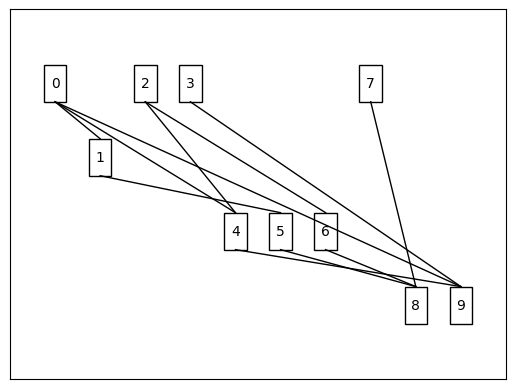

In [13]:
levels = calc_levels(g2)
for i,n in enumerate(g2.nodes): n.x = i
draw_graph(g2)

#### Single pass from top to bottom
* Perform the Hungarian assignment step for the first level and every subsequent level
* For the first level, there won't be any connection cost, as these nodes don't have input nodes

In [14]:
wc = 0.1  # Weight of cost associated with distance of node to the center
wd = 1.0  # Weight of cost associated with difference in horizontal positions of 2 nodes
verbose = False

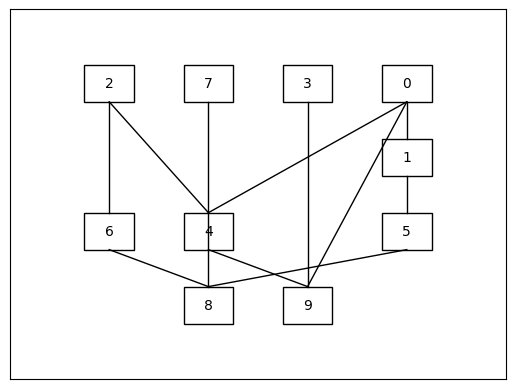

In [15]:
level_lens = [len(level) for level in levels]
largest_level_len = max(level_lens)
candidate_xs = [i-(largest_level_len-1)//2 for i in range(largest_level_len)]
xdata = [None] * len(g2.nodes)
for cur_level in levels:
    cur_level_len = len(cur_level)
    cur_level_nodes = [g2.nodes[ni] for ni in cur_level]
    cost_matrix = np.zeros((cur_level_len, largest_level_len))  # Cost of placing each cur_level node at each candidate x-coordinate
    M = Munkres()
    for ni,n in enumerate(cur_level_nodes):
        for xi,x in enumerate(candidate_xs):
            cc = abs(x)  # Cost of placing node away from the center
            cd = 0       # Cost of placing node away from connected input node
            for in_node in n._in_nodes:
                cd += abs(x - xdata[in_node._idx])
            cost_matrix[ni,xi] = wc*cc + wd*cd
    best_path = M.compute(cost_matrix)
    for ni, xi in best_path:
        xdata[cur_level_nodes[ni]._idx] = candidate_xs[xi]
    if verbose:
        print(f'cost_matrix={cost_matrix}')
        print(f'best_path={best_path}')
        print(f'xs={xdata}')
        print('')

for ni,x in enumerate(xdata):
    g2.nodes[ni].x = x
draw_graph(g2)

#### Multiple passes with various permutations for input level

In [16]:
def best_layout_one_fixed_level(g:MavGraph, levels:List[List[int]], fixed_level, fixed_xs:List[int], wc=1, wd=10, verbose=False):
    level_lens = [len(level) for level in levels]
    largest_level_len = max(level_lens)
    candidate_xs = [i-(largest_level_len-1)//2 for i in range(largest_level_len)]
    xs = [None] * len(g.nodes)
    total_cost = 0
    M = Munkres()

    # Fixed level
    for xi, ni in enumerate(levels[fixed_level]): 
        xs[g.nodes[ni]._idx] = fixed_xs[xi]
        total_cost += wc*abs(fixed_xs[xi])

    # Levels before fixed level
    if fixed_level > 0:
        for cur_level in levels[fixed_level-1::-1]:
            cur_level_len = len(cur_level)
            cur_level_nodes = [g.nodes[ni] for ni in cur_level]
            cost_matrix = np.zeros((cur_level_len, largest_level_len))  # Cost of placing each cur_level node at each candidate x-coordinate
            for ni,n in enumerate(cur_level_nodes):
                for xi,x in enumerate(candidate_xs):
                    cc = abs(x)  # Cost of placing node away from the center
                    cd = 0       # Cost of placing node away from connected output node
                    for out_node in n._out_nodes:
                        if xs[out_node._idx] is not None:
                            cd += abs(x - xs[out_node._idx])
                        else:
                            pass  # Skip connection between levels before and after fixed_level. Will be counted in other direction.
                    cost_matrix[ni,xi] = wc*cc + wd*cd
            best_path = M.compute(cost_matrix.copy())
            level_cost = 0
            for ni, xi in best_path:
                xs[cur_level_nodes[ni]._idx] = candidate_xs[xi]
                level_cost += cost_matrix[ni,xi]
            total_cost += level_cost
            if verbose:
                print(f'cost_matrix={cost_matrix}')
                print(f'best_path={best_path}')
                print(f'xs={xs}')
                print('')

    # Levels after fixed level
    if fixed_level < len(levels) -1:
        for cur_level in levels[fixed_level+1:]:
            cur_level_len = len(cur_level)
            cur_level_nodes = [g.nodes[ni] for ni in cur_level]
            cost_matrix = np.zeros((cur_level_len, largest_level_len))  # Cost of placing each cur_level node at each candidate x-coordinate
            for ni,n in enumerate(cur_level_nodes):
                for xi,x in enumerate(candidate_xs):
                    cc = abs(x)  # Cost of placing node away from the center
                    cd = 0       # Cost of placing node away from connected input node
                    for in_node in n._in_nodes:
                        if xs[in_node._idx] is not None:
                            cd += abs(x - xs[in_node._idx])
                        else:
                            pass  # Skip connection between levels before and after fixed_level. Will be counted in other direction.
                    cost_matrix[ni,xi] = wc*cc + wd*cd
            best_path = M.compute(cost_matrix.copy())
            level_cost = 0
            for ni, xi in best_path:
                xs[cur_level_nodes[ni]._idx] = candidate_xs[xi]
                level_cost += cost_matrix[ni,xi]
            total_cost += level_cost
            if verbose:
                print(f'cost_matrix={cost_matrix}')
                print(f'best_path={best_path}')
                print(f'xs={xs}')
                print('')
    return xs, total_cost

In [17]:
in_level_len = len(levels[0])
in_xs_0 = [i-(in_level_len-1)//2 for i in range(in_level_len)]
in_perms = list(itertools.permutations(in_xs_0))
num_perms = len(in_perms)
total_costs = [None] * num_perms
xdata = np.zeros((num_perms, len(g2.nodes)))
for prmi, in_xs in enumerate(in_perms):
    xdata[prmi,:], total_costs[prmi] = best_layout_one_fixed_level(g2, levels, 0, in_xs)

In [18]:
[a for a in zip(xdata, total_costs)]

[(array([-1., -1.,  0.,  1.,  0., -1.,  1.,  2.,  1.,  0.]), 78.0),
 (array([-1., -1.,  0.,  2.,  0., -1.,  1.,  1.,  1.,  0.]), 78.0),
 (array([-1., -1.,  1.,  0.,  0., -1.,  1.,  2.,  1.,  0.]), 68.0),
 (array([-1., -1.,  1.,  2.,  0., -1.,  1.,  0.,  0., -1.]), 88.0),
 (array([-1., -1.,  2.,  0.,  0., -1.,  2.,  1.,  1.,  0.]), 79.0),
 (array([-1., -1.,  2.,  1.,  0., -1.,  2.,  0.,  0., -1.]), 99.0),
 (array([ 0.,  0., -1.,  1.,  0.,  1., -1.,  2.,  1.,  0.]), 67.0),
 (array([ 0.,  0., -1.,  2.,  0.,  1., -1.,  1.,  1.,  0.]), 67.0),
 (array([ 0.,  0.,  1., -1.,  0., -1.,  1.,  2.,  1.,  0.]), 67.0),
 (array([ 0.,  0.,  1.,  2.,  0., -1.,  1., -1., -1.,  0.]), 67.0),
 (array([ 0.,  0.,  2., -1.,  1.,  0.,  2.,  1.,  1.,  0.]), 68.0),
 (array([ 0.,  0.,  2.,  1.,  1.,  0.,  2., -1.,  0.,  1.]), 68.0),
 (array([ 1.,  1., -1.,  0.,  0.,  1., -1.,  2.,  1.,  0.]), 68.0),
 (array([ 1.,  1., -1.,  2.,  0.,  1., -1.,  0.,  0.,  1.]), 68.0),
 (array([ 1.,  1.,  0., -1.,  0.,  1., -1.,  2.,

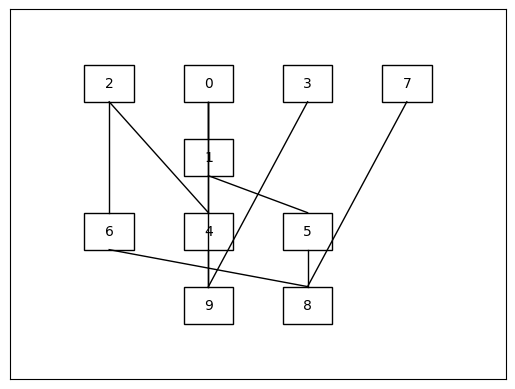

In [19]:
best_idx = np.argmin(total_costs)
best_xs = xdata[best_idx]
for ni,xdata in enumerate(best_xs):
    g2.nodes[ni].x = xdata
draw_graph(g2)

In [20]:
g2

Inputs: ['0', '2', '3', '7']
Outputs: ['8', '9']
All nodes:
    MavNode: name=0; (x,y)=(0.0,0); in=[], out=['1', '9', '4']
    MavNode: name=1; (x,y)=(0.0,1); in=['0'], out=['5']
    MavNode: name=2; (x,y)=(-1.0,0); in=[], out=['4', '6']
    MavNode: name=3; (x,y)=(1.0,0); in=[], out=['9']
    MavNode: name=4; (x,y)=(0.0,2); in=['2', '0'], out=['9']
    MavNode: name=5; (x,y)=(1.0,2); in=['1'], out=['8']
    MavNode: name=6; (x,y)=(-1.0,2); in=['2'], out=['8']
    MavNode: name=7; (x,y)=(2.0,0); in=[], out=['8']
    MavNode: name=8; (x,y)=(1.0,3); in=['6', '5', '7'], out=[]
    MavNode: name=9; (x,y)=(0.0,3); in=['4', '3', '0'], out=[]

#### Multiple pases from central level

In [21]:
lvl2_len = len(levels[2])
xs_2 = [i-(lvl2_len-1)//2 for i in range(lvl2_len)]
xs_2_perms = list(itertools.permutations(xs_2))
num_xs_2_perms = len(xs_2_perms)
total_costs = [None] * num_xs_2_perms
xdata = np.zeros((num_xs_2_perms, len(g2.nodes)))
for prmi, xs_2 in enumerate(xs_2_perms):
    xdata[prmi,:], total_costs[prmi] = best_layout_one_fixed_level(g2, levels, 2, xs_2)

In [22]:
[a for a in zip(xdata, total_costs)]

[(array([ 0.,  0., -1.,  1., -1.,  0.,  1.,  2.,  1.,  0.]), 77.0),
 (array([ 0.,  1., -1.,  1., -1.,  1.,  0.,  2.,  1.,  0.]), 78.0),
 (array([-1., -1.,  1.,  0.,  0., -1.,  1.,  2.,  1.,  0.]), 68.0),
 (array([ 0.,  1., -1.,  1.,  0.,  1., -1.,  2.,  1.,  0.]), 68.0),
 (array([-1., -1.,  1.,  0.,  1., -1.,  0.,  2.,  0., -1.]), 98.0),
 (array([ 0.,  0., -1.,  1.,  1.,  0., -1.,  2.,  0.,  1.]), 77.0)]

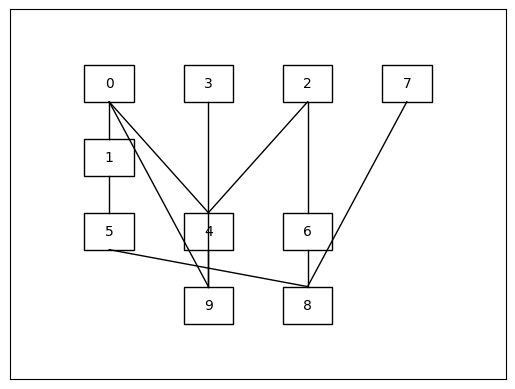

In [23]:
best_idx = np.argmin(total_costs)
best_xs = xdata[best_idx]
for ni,xdata in enumerate(best_xs):
    g2.nodes[ni].x = xdata
draw_graph(g2)

In [24]:
g2

Inputs: ['0', '2', '3', '7']
Outputs: ['8', '9']
All nodes:
    MavNode: name=0; (x,y)=(-1.0,0); in=[], out=['1', '9', '4']
    MavNode: name=1; (x,y)=(-1.0,1); in=['0'], out=['5']
    MavNode: name=2; (x,y)=(1.0,0); in=[], out=['4', '6']
    MavNode: name=3; (x,y)=(0.0,0); in=[], out=['9']
    MavNode: name=4; (x,y)=(0.0,2); in=['2', '0'], out=['9']
    MavNode: name=5; (x,y)=(-1.0,2); in=['1'], out=['8']
    MavNode: name=6; (x,y)=(1.0,2); in=['2'], out=['8']
    MavNode: name=7; (x,y)=(2.0,0); in=[], out=['8']
    MavNode: name=8; (x,y)=(1.0,3); in=['6', '5', '7'], out=[]
    MavNode: name=9; (x,y)=(0.0,3); in=['4', '3', '0'], out=[]

#### Experimental cells

In [25]:
levels

[[0, 2, 3, 7], [1], [4, 5, 6], [8, 9]]

In [26]:
level_lens = [len(level) for level in levels]
level_lens

[4, 1, 3, 2]

In [27]:
largest_level_len = max(level_lens)
largest_level_len

4

In [28]:
list(itertools.permutations(levels[-1]))

[(8, 9), (9, 8)]

In [29]:
prev_level = levels[0]
prev_level_len = len(prev_level)
prev_level_nodes = [g2.nodes[ni] for ni in prev_level]
prev_level_nodes

[MavNode: name=0; (x,y)=(-1.0,0); in=[], out=['1', '9', '4'],
 MavNode: name=2; (x,y)=(1.0,0); in=[], out=['4', '6'],
 MavNode: name=3; (x,y)=(0.0,0); in=[], out=['9'],
 MavNode: name=7; (x,y)=(2.0,0); in=[], out=['8']]

In [30]:
cur_level = levels[1]
cur_level_len = len(cur_level)
cur_level_nodes = [g2.nodes[ni] for ni in cur_level]
cur_level_nodes

[MavNode: name=1; (x,y)=(-1.0,1); in=['0'], out=['5']]

In [31]:
prev_level_len = len(prev_level)
prev_level_xs = [i-(prev_level_len-1)//2 for i in range(prev_level_len)]
prev_level_xs

[-1, 0, 1, 2]

In [32]:
list(itertools.permutations(prev_level_xs))

[(-1, 0, 1, 2),
 (-1, 0, 2, 1),
 (-1, 1, 0, 2),
 (-1, 1, 2, 0),
 (-1, 2, 0, 1),
 (-1, 2, 1, 0),
 (0, -1, 1, 2),
 (0, -1, 2, 1),
 (0, 1, -1, 2),
 (0, 1, 2, -1),
 (0, 2, -1, 1),
 (0, 2, 1, -1),
 (1, -1, 0, 2),
 (1, -1, 2, 0),
 (1, 0, -1, 2),
 (1, 0, 2, -1),
 (1, 2, -1, 0),
 (1, 2, 0, -1),
 (2, -1, 0, 1),
 (2, -1, 1, 0),
 (2, 0, -1, 1),
 (2, 0, 1, -1),
 (2, 1, -1, 0),
 (2, 1, 0, -1)]

In [33]:
candidate_xs = [i-(largest_level_len-1)//2 for i in range(largest_level_len)]
candidate_xs

[-1, 0, 1, 2]

In [34]:
xdata = [None] * len(g2.nodes)
for i,n in enumerate(prev_level_nodes):
    xdata[n._idx] = prev_level_xs[i]
xdata

[-1, None, 0, 1, None, None, None, 2, None, None]

## Slightly improved viewer
Draw arcs rather than straight lines: can visualize more complex model

In [35]:
def append_arc_coords(x, y, cx, cy, r, quadrant, ccw, num_points):
    if ccw:
        t = np.linspace(np.pi/2*(quadrant-1), np.pi/2*quadrant, num_points)
    else:
        t = np.linspace(np.pi/2*quadrant, np.pi/2*(quadrant-1), num_points)
    xdata = cx + r*np.cos(t)
    ydata = cy - r*np.sin(t)  # Negative because y-axis is inverted on graph
    x += list(xdata)
    y += list(ydata)

def get_connection_arc_coords(g:MavGraph, n0:MavNode, n1:MavNode):

    # Local parameters
    r = 0.1  # Arc radius
    na = 10  # Number of points per arc

    # Aliases
    x0, y0, x1, y1 = n0.x, n0.y, n1.x, n1.y

    # Determine x-coordinate of main vertical segment
    nodes_in_x0_line = [n for n in g.nodes if n.x == x0 and n.y > y0 and n.y < y1]
    nodes_in_x1_line = [n for n in g.nodes if n.x == x1 and n.y > y0 and n.y < y1]
    if x0 == x1:
        # Vertical connection: bend very slightly if other blocks are in the way
        if nodes_in_x0_line:
            if x0 >= 0:
                x_main = x0 + 0.5 - (1-g.nw)*0.4
            else:
                x_main = x0 - 0.5 + (1-g.nw)*0.4
        else:
            x_main = x0
    elif abs(x0) <= abs(x1):
        # Moving from centre towards border
        if not nodes_in_x1_line:
            # Nothing in the way above output node
            x_main = x1
        elif not nodes_in_x0_line:
            # Nothing in the way below input node
            x_main = x0
        elif x0 < x1:
            # Moving from centre towards right border
            x_main = x1 - 0.5 + (1-g.nw)*0.1
        else:
            # Moving from centre towards left border
            x_main = x1 + 0.5 - (1-g.nw)*0.1
    else:
        # Moving from border in towards centre
        if not nodes_in_x0_line:
            # Nothing in the way below input node
            x_main = x0
        elif not nodes_in_x1_line:
            # Nothing in the way above output node
            x_main = x1
        elif x0 < x1:
            # Moving from left border towards centre
            x_main = x0 + 0.5 + (1-g.nw)*0.1
        else:
            # Moving from right border towards centre
            x_main = x0 - 0.5 - (1-g.nw)*0.1
            
    # Draw 4 arcs: 
    # * n0 to upper horizontal line
    # * upper horizontal line to main vertical line
    # * main vertical line to lower horizontal line
    # * lower horizontal line to n1
    # If coordinates for arcs are placed in the correct order, straight lines will automatically connect them
    xdata, ydata = [x0], [y0+g.nh/2]

    # n0 to upper horizontal line
    if x0 < x_main:
        # CCW 3rd quadrant arc with centre to the right of x0
        cx, cy, q, ccw = x0+r, y0+g.nh/2, 3, True
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)
    elif x0 > x_main:
        # Clockwise 4th quadrant arc with centre to the left of x0
        cx, cy, q, ccw = x0-r, y0+g.nh/2, 4, False
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)
    
    # Upper horizontal to main vertical line
    if x0 < x_main:
        # Clockwise 1st quadrant arc with centre to the left of x_main
        cx, cy, q, ccw = x_main-r, y0+g.nh/2+r+r, 1, False
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)
    elif x0 > x_main:
        # CCW 2nd quadrant arc with centre to the right of x_main
        cx, cy, q, ccw = x_main+r, y0+g.nh/2+r+r, 2, True
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)

    # main vertical line to lower horizontal line
    if x_main < x1:
        # CCW 3rd quadrant arc with centre to the right of x_main
        cx, cy, q, ccw = x_main+r, y1-g.nh/2-r-r, 3, True
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)
    elif x_main > x1:
        # Clockwise 4th quadrant arc with centre to the left of x_main
        cx, cy, q, ccw = x_main-r, y1-g.nh/2-r-r, 4, False
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)

    # lower horizontal line to n1
    if x_main < x1:
        # Clockwise 1st quadrant arc with centre to the left of x1
        cx, cy, q, ccw = x1-r, y1-g.nh/2, 1, False
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)
    elif x_main > x1:
        # CCW 2nd quadrant arc with centre to the right of x1
        cx, cy, q, ccw = x1+r, y1-g.nh/2, 2, True
        append_arc_coords(xdata, ydata, cx, cy, r, q, ccw, na)
    
    xdata += [x1]
    ydata += [y1-g.nh/2]
    return xdata,ydata

In [36]:
def draw_graph_2(g:MavGraph):
    fig, ax = plt.subplots()
    x_lim, y_lim = (0,0), (0,0)
    for c in g.connections:
        xdata, ydata = get_connection_arc_coords(g, c.from_node, c.to_node)
        line = lines.Line2D(xdata=xdata, ydata=ydata, linewidth=1, color=[0,0,0])
        ax.add_line(line)
    for n in g.nodes:
        rect = patches.Rectangle((n.x - g.nw/2, n.y - g.nh/2), g.nw, g.nh, 
                                linewidth=1, edgecolor=[0,0,0], facecolor=[1,1,1])
        ax.add_patch(rect)
        x_lim = (min((x_lim[0], n.x-1)), max((x_lim[1], n.x+1)))
        y_lim = (min((y_lim[0], n.y-1)), max((y_lim[1], n.y+1)))
        ax.text(n.x, n.y, n.name, horizontalalignment='center', verticalalignment='center')
    ax.set_xlim(left=x_lim[0], right=x_lim[1])
    ax.set_ylim(bottom=y_lim[1], top=y_lim[0])
    ax.set_yticks([])
    ax.set_xticks([])

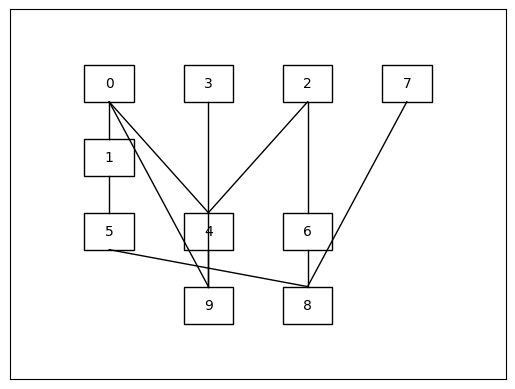

In [37]:
draw_graph(g2)

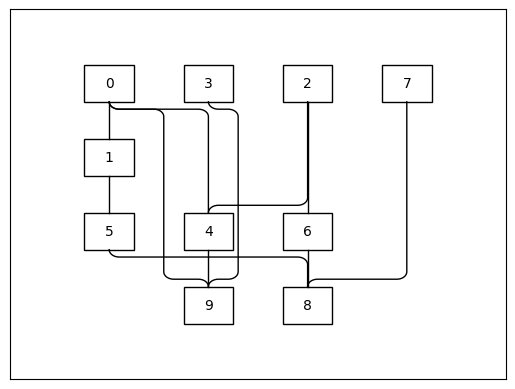

In [38]:
draw_graph_2(g2)

## Larger architecture example

In [39]:
skip_prob_decay = 0.5
nodes_per_level = [1,2,3,4]
num_nodes = sum(nodes_per_level)
levels = []
for i,num in enumerate(nodes_per_level):
    levels += [i]*num
print(levels)
print(np.where(np.array(levels)<3, levels, 0))

p0 = [skip_prob_decay**(3-level) for level in levels if level <= 3]
p = np.array(p0) / sum(p0)
np.random.choice(list(range(len(p))), p=p)

[0, 1, 1, 2, 2, 2, 3, 3, 3, 3]
[0 1 1 2 2 2 0 0 0 0]


6

In [40]:
def create_random_sample_graph_2(nodes_per_level, rep_prob_decay, skip_prob_decay, num_connections):
    """
    nodes_per_level is a list of the number of nodes on each level, e.g. [1,2,3,4,3,2,1]
    rep_prob_decay is the fraction by which the probability of a node being chosen as input
        is multiplied each time that node is chosen
    skip_prob_decay is the fraction by which the probability of a node being chosen as input
        to another node decays when the candidact input node is moved to an earlier level
    """
    # Create nodes
    num_levels = len(nodes_per_level)
    num_nodes = sum(nodes_per_level)
    levels = []
    for i,num in enumerate(nodes_per_level):
        levels += [i]*num
    nodes = [MavNode(str(ni), 0, 0) for ni in range(num_nodes)]

    # Create main input connection for each node
    p0 = np.array([skip_prob_decay**(num_levels-lvl) for lvl in levels])  # Unscaled probability of picking each node as input
    connection_tuples: List[Tuple[int]] = []
    connections: List[MavConnection] = []
    for n2,node in enumerate(nodes):
        level = levels[n2]
        if level==0: continue  # Input node has no inputs
        p1 = np.where(np.array(levels)<level, p0, 0)
        p = p1 / np.sum(p1)
        n1 = np.random.choice(list(range(len(p))), p=p)
        connection_tuples.append((n1,n2))
        connections.append(MavConnection(nodes[n1], nodes[n2]))
        p0[n1] *= rep_prob_decay

    # Create main output connection for each node
    p0 = np.array([skip_prob_decay**lvl for lvl in levels])  # Unscaled probability of picking each node as output
    for n1,node in enumerate(nodes):
        level = levels[n1]
        if level==num_levels-1: continue  # Output node has no outputs
        if [tpl[1] for tpl in connection_tuples if tpl[0]==n1]: continue  # Node already has outputs
        p1 = np.where(np.array(levels)>level, p0, 0)
        p = p1 / np.sum(p1)
        n2 = np.random.choice(list(range(len(p))), p=p)
        connection_tuples.append((n1,n2))
        connections.append(MavConnection(nodes[n1], nodes[n2]))
        p0[n2] *= rep_prob_decay

    # Create additional connections
    num_attempts = 0
    while len(connections) < num_connections and num_attempts < num_connections*10:
        n1 = random.randint(0, num_nodes-1)
        n2 = random.randint(0, num_nodes-1)
        if n1>n2: n_temp = n1; n1 = n2; n2 = n_temp
        reject = n1==n2 or (n1,n2) in connection_tuples or levels[n1] >= levels[n2]
        if not reject:
            connection_tuples.append((n1,n2))
            connections.append(MavConnection(nodes[n1], nodes[n2]))
        num_attempts += 1
    return MavGraph(nodes=nodes, connections=connections)

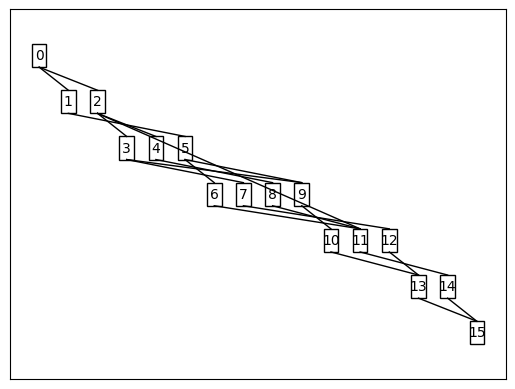

In [41]:
random.seed(2)
g3 = create_random_sample_graph_2([1,2,3,4,3,2,1], 0.1, 0.1, 20)
levels = calc_levels(g3)
for i,n in enumerate(g3.nodes): n.x = i
draw_graph(g3)

In [42]:
level_lens = [len(level) for level in levels]
largest_level_idx = np.argmax(level_lens)
largest_level_len = level_lens[largest_level_idx]
xs = [i-(largest_level_len-1)//2 for i in range(largest_level_len)]
xs_perms = list(itertools.permutations(xs))
num_xs_perms = len(xs_perms)
total_costs = [None] * num_xs_perms
xdata = np.zeros((num_xs_perms, len(g3.nodes)))
for prmi, xs_perm in enumerate(xs_perms):
    xdata[prmi,:], total_costs[prmi] = best_layout_one_fixed_level(g3, levels, largest_level_idx, xs_perm)

In [43]:
[a for a in zip(xdata, total_costs)]

[(array([ 0., -1.,  0.,  0.,  1., -1., -1.,  0.,  1.,  2.,  2.,  0., -1.,
          1.,  0.,  0.]),
  151.0),
 (array([ 0., -1.,  0.,  0.,  2., -1., -1.,  0.,  2.,  1.,  1.,  0., -1.,
          1.,  0.,  0.]),
  141.0),
 (array([ 0., -1.,  0.,  1.,  0., -1., -1.,  1.,  0.,  2.,  2.,  0.,  1.,
          1.,  0.,  0.]),
  101.0),
 (array([ 0., -1.,  0.,  0.,  2., -1., -1.,  1.,  2.,  0.,  0., -1.,  1.,
          0., -1.,  0.]),
  121.0),
 (array([ 0., -1.,  0.,  1.,  0., -1., -1.,  2.,  0.,  1.,  1.,  0.,  2.,
          1.,  0.,  0.]),
  91.0),
 (array([ 0., -1.,  0.,  0.,  1., -1., -1.,  2.,  1.,  0.,  0., -1.,  2.,
          0., -1.,  0.]),
  121.0),
 (array([ 0.,  0.,  1., -1.,  1.,  0.,  0., -1.,  1.,  2.,  2.,  1., -1.,
          0.,  1.,  0.]),
  142.0),
 (array([ 0.,  1.,  0.,  0.,  2.,  1.,  0., -1.,  2.,  1.,  1.,  0., -1.,
          1.,  0.,  0.]),
  121.0),
 (array([ 0.,  0.,  1.,  1., -1.,  0.,  0.,  1., -1.,  2.,  2.,  0.,  1.,
          1.,  0.,  0.]),
  111.0),
 (array([ 0

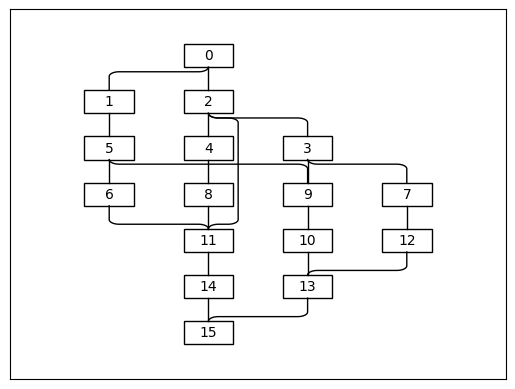

In [44]:
best_idx = np.argmin(total_costs)
best_xs = xdata[best_idx]
for ni,x in enumerate(best_xs):
    g3.nodes[ni].x = x
draw_graph_2(g3)